# Analysis

## 1. Loading Data and Modules

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import tensorflow as tf

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [3]:
from helper.utils import BondPricing
from helper.synthesis import generate_pointwise_data

In [3]:
generate_pointwise_data()

100%|██████████| 60000/60000 [00:00<00:00, 212525.50it/s]


Data successfully generated!


In [4]:
from analysis.pointwise.model import load_data, init_model, train_model

params_range_train, params_range_test, price_train, price_test = load_data()

## 2. Training Model

In [5]:
model = init_model()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  224       
                                                                 
 dense_1 (Dense)             multiple                  1056      
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
____________________________________________________

2023-02-12 12:23:49,440 | INFO: | model.py | train_model | 222: Beginning training for model dense with vasicek


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]

2023-02-12 12:25:58,979 | INFO: | model.py | train_model | 271: Saved weights to file: weights/pointwise/pointwise_weights_dense_vasicek.h5


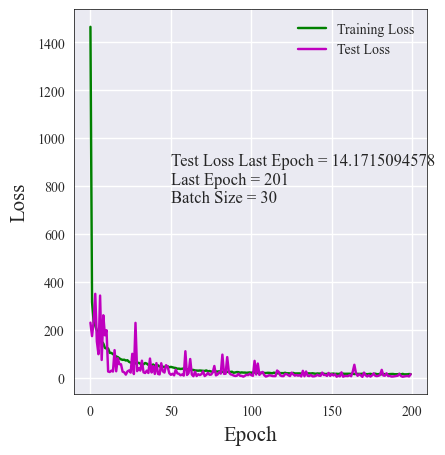

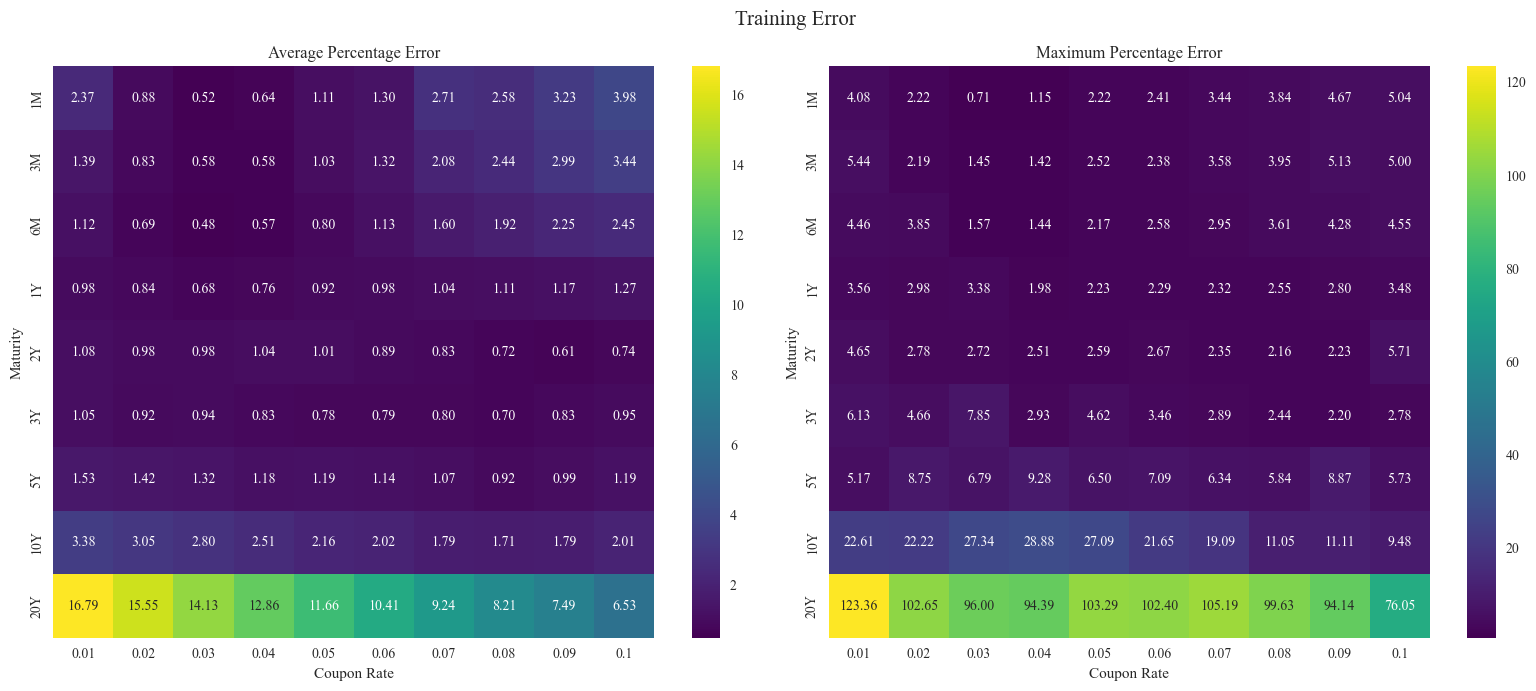

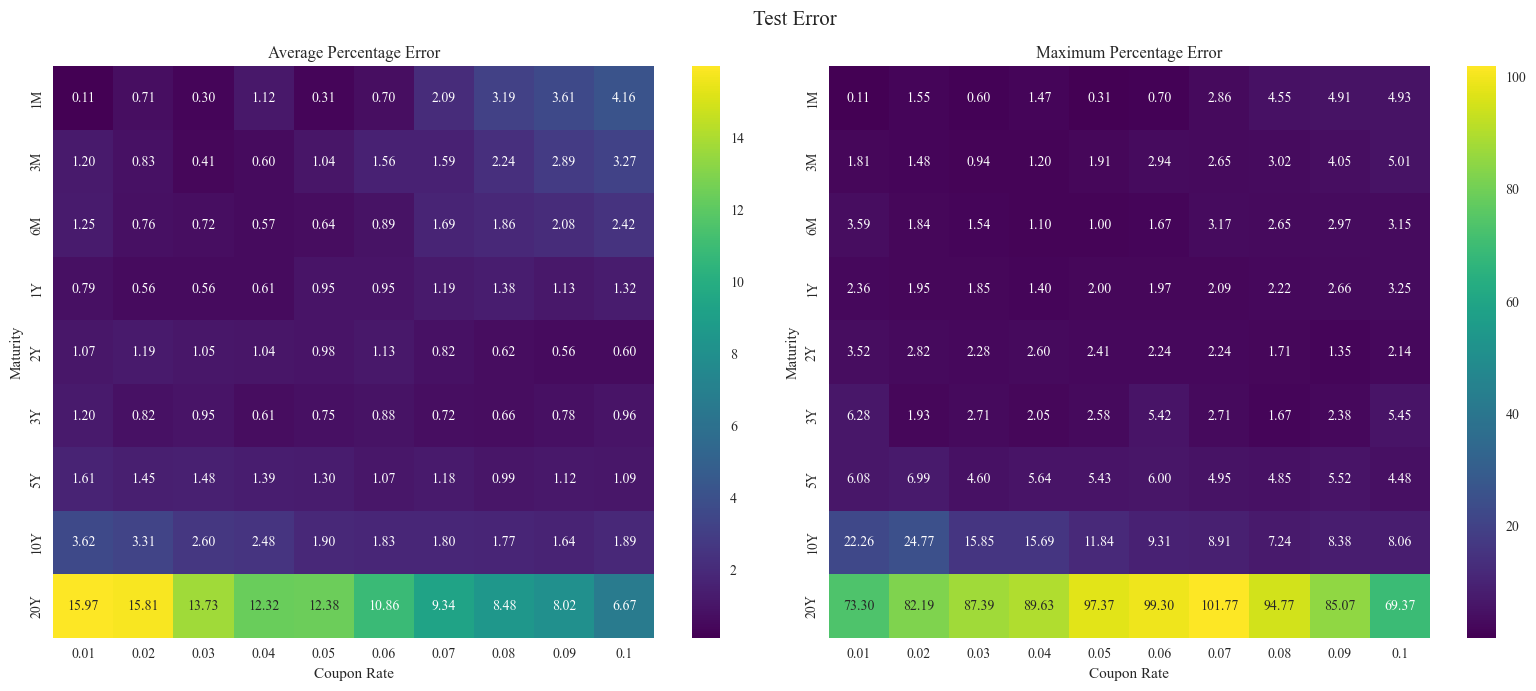

In [6]:
train_model(model = model, epochs = 200, plot = True);

## Synthetic Calibration

2023-02-12 12:27:49,407 | INFO: | model.py | calibrate_synthetic | 494: Beginning calibration for model dense with vasicek


100%|██████████| 10000/10000 [1:31:08<00:00,  1.83it/s]  

2023-02-12 13:58:58,337 | INFO: | model.py | calibrate_synthetic | 538: Calibration complete! change in parameters: 13.744580191802987
2023-02-12 13:58:58,389 | INFO: | model.py | calibrate_synthetic | 542: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek.dat


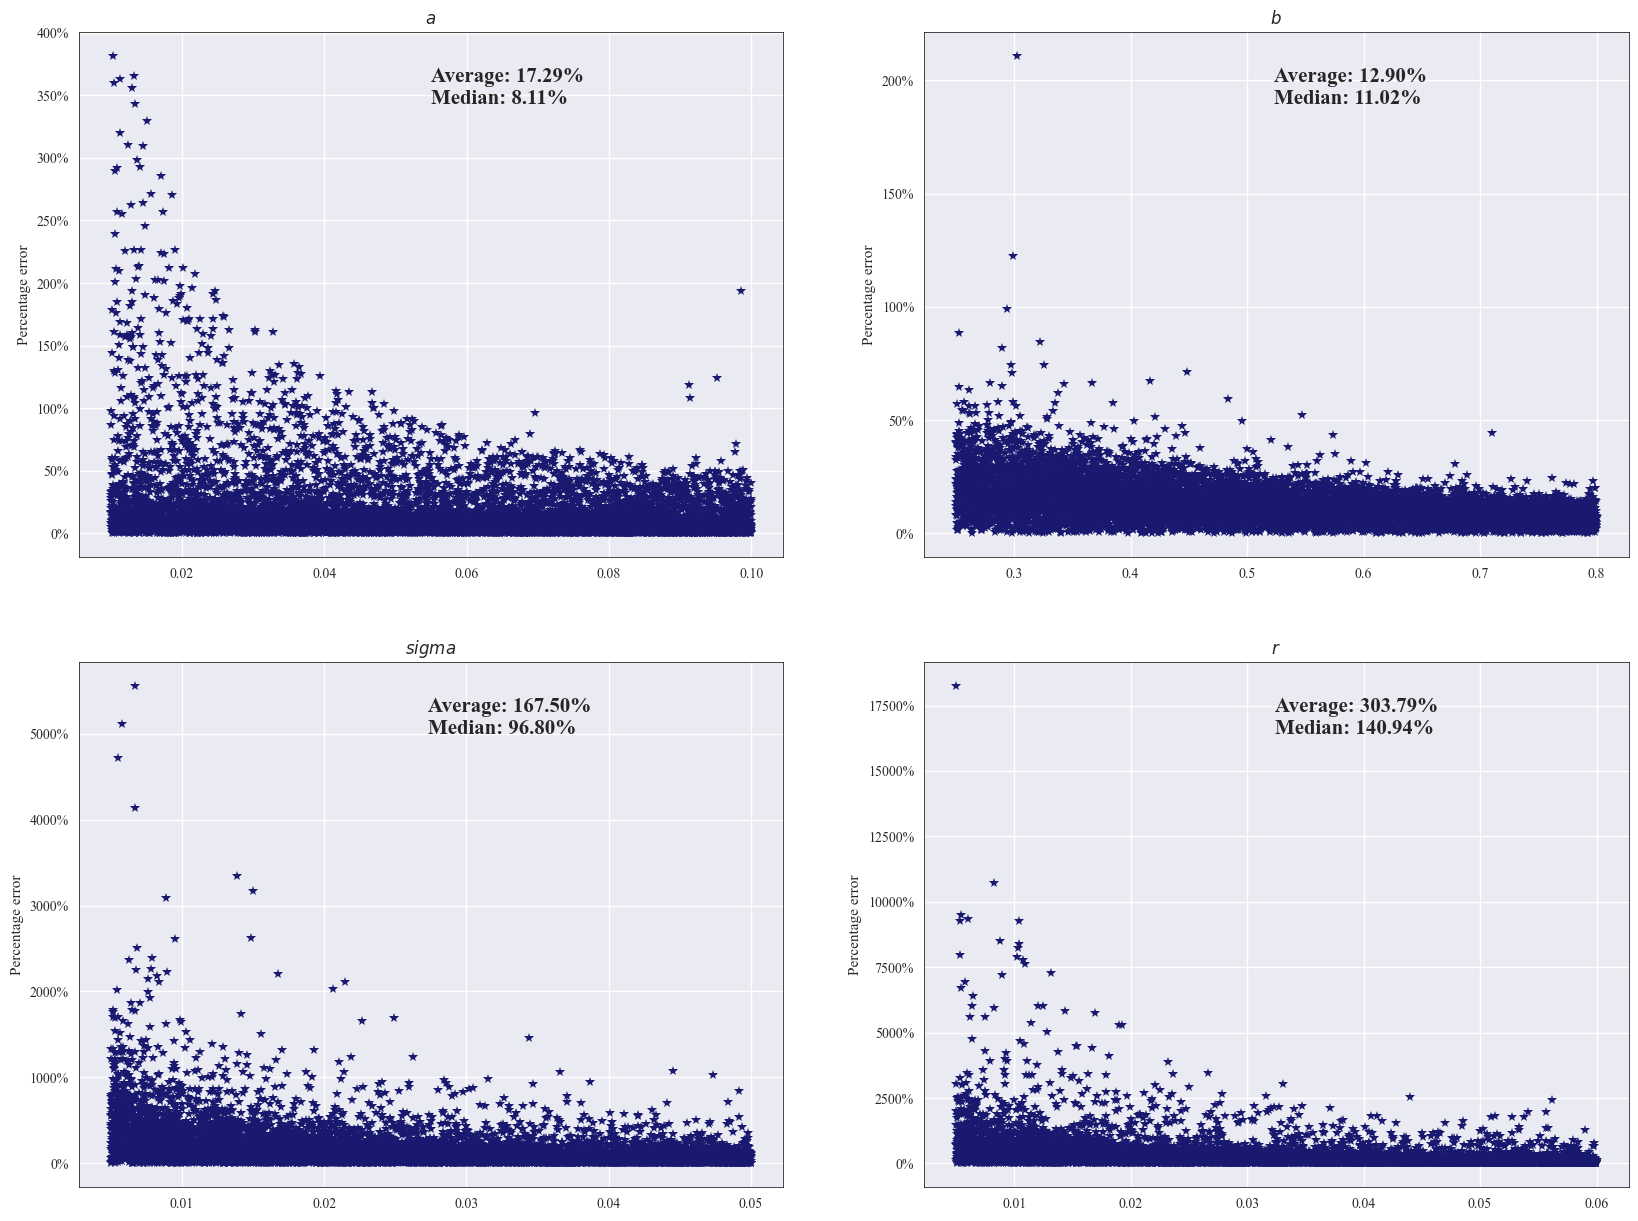

In [7]:
from analysis.pointwise.model import calibrate_synthetic

calibrate_synthetic(
        model, calibration_size = 10_000, epochs = 1000, model_type = 'dense', parameterization =
        'vasicek',
        plot = True,
        verbose_length = 500
        )

## 3. Market Calibration

In [8]:
def bond_price(par, T, ytm, coup, freq = 2):
    freq = float(freq)
    periods = T * freq
    coupon = coup * par / freq
    dt = [(i + 1) / freq for i in range(int(periods))]
    price = sum([coupon / (1 + ytm / freq) ** (freq * t) for t in dt]) + par / (1 + ytm / freq) ** (freq * T)
    return price

bond_price(par = 100, T = 1, ytm = 0.02, coup = 0.04, freq = 1)

101.96078431372548

In [9]:
import pandas as pd
import numpy as np
#
# df = pd.read_csv("market_data/United States 30-Year Bond Yield Historical Data.csv")
# df.columns = [x.strip() for x in df.columns]
# df = df[['Date', 'Price']]
# df.Date = pd.to_datetime(df.Date)
# df.set_index('Date', inplace = True)
# df = df[::-1]
# df['Time to Expiry'] = (pd.to_datetime("2052-11-15") - df.index).days / 365
# df['Bond Price'] = df.apply(
#     lambda x: bond_price(par = 100, T = x[1], ytm = x[0] / 100, coup = 4 / 100, freq = 2), axis = 1
#     )

# df.to_csv("market_data/30Y_cleaned.csv")

In [10]:
expiries = {
        "1M" : "2023-03-07",
        "3M" : "2023-05-04",
        '6M' : "2023-08-03",
        '1Y' : "2024-01-25",
        '2Y' : "2025-01-31",
        "3Y" : "2026-01-15",
        "5Y" : "2028-01-31",
        '10Y': "2032-11-15",
        '20Y': "2042-11-15",
        "30Y": "2052-11-15"
        }

coupons = {
        "1M" : 0,
        '3M' : 0,
        "6M" : 0,
        "1Y" : 0,
        '2Y' : 4.125 / 100,
        '3Y' : 3.875 / 100,
        '5Y' : 3.5 / 100,
        '10Y': 4.125 / 100,
        '20Y': 4 / 100,
        '30Y': 4 / 100
        }

In [11]:
from analysis.pointwise.model import calibrate_to_market_data, init_model, load_weights

model = init_model()

load_weights(model)

Model: "dense_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  224       
                                                                 
 dense_5 (Dense)             multiple                  1056      
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             multiple                  1056      
                                                                 
 dense_7 (Dense)             multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
__________________________________________________

In [18]:
initial_parameters = np.array([1, 0.04, 0.05, 0.5, 0.02], dtype = np.float64)

maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '10Y', '20Y', '30Y']

for maturity in maturities:

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv')

    calibrate_to_market_data(
        model = model, market_data = df['Bond Price'], initial_parameters = initial_parameters,
        time_to_expiry = df['Time to Expiry'], verbose_length = 500, epochs = 1000, maturity = maturity
        )

2023-02-12 14:21:47,295 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 1M maturity


100%|██████████| 303/303 [02:18<00:00,  2.19it/s]

2023-02-12 14:24:05,767 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.027599620211884154
2023-02-12 14:24:05,769 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_1M.dat
2023-02-12 14:24:05,775 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 3M maturity



100%|██████████| 302/302 [02:11<00:00,  2.30it/s]

2023-02-12 14:26:16,843 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.02182157160169251
2023-02-12 14:26:16,845 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_3M.dat
2023-02-12 14:26:16,849 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 6M maturity



100%|██████████| 302/302 [02:15<00:00,  2.24it/s]

2023-02-12 14:28:31,919 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.09847365986949391
2023-02-12 14:28:31,921 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_6M.dat
2023-02-12 14:28:31,926 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 1Y maturity



100%|██████████| 301/301 [02:59<00:00,  1.68it/s]

2023-02-12 14:31:31,496 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.06354411441970398
2023-02-12 14:31:31,499 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_1Y.dat
2023-02-12 14:31:31,505 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 2Y maturity



100%|██████████| 302/302 [02:59<00:00,  1.69it/s]

2023-02-12 14:34:30,587 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.0330647966557661
2023-02-12 14:34:30,589 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_2Y.dat
2023-02-12 14:34:30,600 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 3Y maturity



100%|██████████| 302/302 [02:34<00:00,  1.95it/s]

2023-02-12 14:37:05,461 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.07643837199395884
2023-02-12 14:37:05,463 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_3Y.dat
2023-02-12 14:37:05,468 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 5Y maturity



100%|██████████| 302/302 [02:49<00:00,  1.78it/s]

2023-02-12 14:39:55,002 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.156528324381108
2023-02-12 14:39:55,004 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_5Y.dat
2023-02-12 14:39:55,009 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 10Y maturity



100%|██████████| 302/302 [02:25<00:00,  2.07it/s]

2023-02-12 14:42:20,932 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.3277449446952867
2023-02-12 14:42:20,934 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_10Y.dat
2023-02-12 14:42:20,939 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 20Y maturity



100%|██████████| 302/302 [02:44<00:00,  1.84it/s]

2023-02-12 14:45:05,246 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.5511434210557598
2023-02-12 14:45:05,248 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_20Y.dat
2023-02-12 14:45:05,253 | INFO: | model.py | calibrate_to_market_data | 624: Beginning calibration for model dense with vasicek for 30Y maturity



100%|██████████| 302/302 [02:44<00:00,  1.84it/s]

2023-02-12 14:47:49,739 | INFO: | model.py | calibrate_to_market_data | 674: Calibration complete! change in parameters: 0.39423990536572573
2023-02-12 14:47:49,742 | INFO: | model.py | calibrate_to_market_data | 679: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_30Y.dat


In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize = (25, 3))

for i, maturity in enumerate(maturities):
    calib = pd.read_table(f"data/pointwise/pointwise_params_market_calibrated_dense_vasicek_{maturity}.dat", sep = " ", header = None)

    # (100 * calib.loc[:, 2] / calib.loc[:, 3]).plot(ax = ax[i]);
    (100 * calib.loc[:, 5]).plot(ax = ax[i]);
    ax[i].plot(df.Price.tolist());
    ax[i].set_title(f'Maturity: {maturity}')

## 4. Sensitivity Analysis

In [17]:
import numpy as np
from tqdm import tqdm
import random
from helper.utils import BondPricing

a_list = np.linspace(0, 1, 500)
b_list = np.linspace(1, 2, 500)
sigma_list = np.linspace(0.001, 0.1, 500)
r_list = np.linspace(0.001, 0.06, 500)
maturities = np.linspace(0.1, 30, 500)

a = 0.02638
b = 2  #(0.053703)
sigma = 0.35384  #(0.00099592)
r = 0.02

random.shuffle(maturities)
random.shuffle(r_list)

sigma_result = []
for sigma_hat, tau in tqdm(zip(sigma_list, maturities)):

    bp = BondPricing(parameters = [a, b, sigma_hat, r])
    price = bp(tau)
    sigma_result.append(price)

a_result = []
for a_hat, tau in tqdm(zip(a_list, maturities)):

    bp = BondPricing(parameters = [a_hat, b, sigma, r])
    price = bp(tau)
    a_result.append(price)

b_result = []
for b_hat, tau in tqdm(zip(b_list, maturities)):

    bp = BondPricing(parameters = [a, b_hat, sigma, r])
    price = bp(tau)
    b_result.append(price)

r_result = []
for r_hat, tau in tqdm(zip(r_list, maturities)):

    bp = BondPricing(parameters = [a, b, sigma, r_hat])
    price = bp(tau)
    r_result.append(price)

a_b_result = []
for a_hat, b_hat in tqdm(zip(a_list, b_list)):

    bp = BondPricing(parameters = [a_hat, b_hat, sigma, r])
    price = bp(1)
    a_b_result.append(price)

500it [00:00, 180167.70it/s]
500it [00:00, 173979.76it/s]
500it [00:00, 239237.05it/s]
500it [00:00, 220081.02it/s]
500it [00:00, 178298.93it/s]


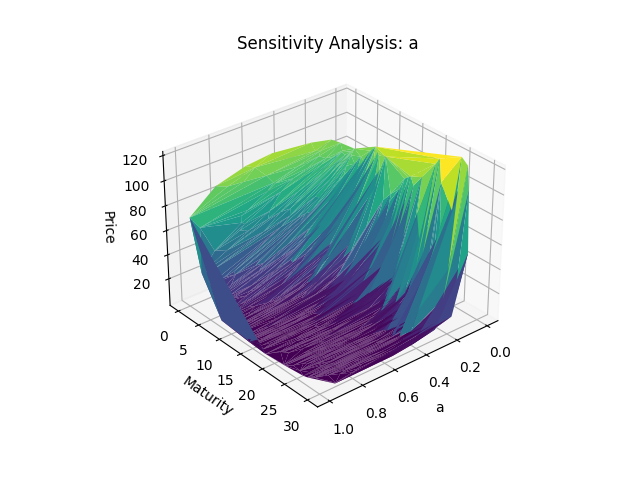

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        a_list, maturities, a_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: a');

ax.set_xlabel('a')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 50, 0)


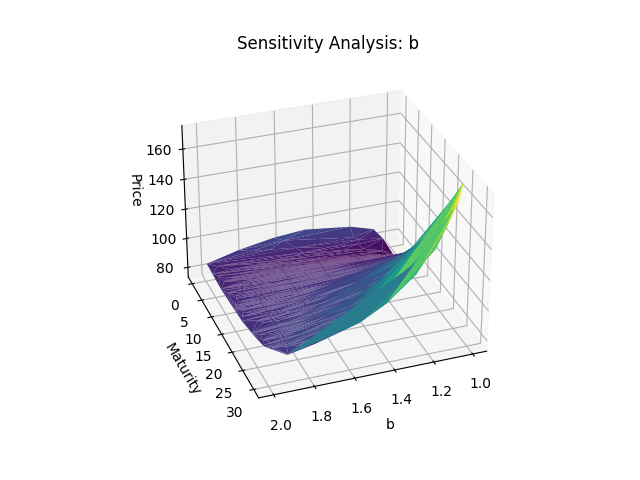

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        b_list, maturities, b_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: b');

ax.set_xlabel('b')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 70, 0)


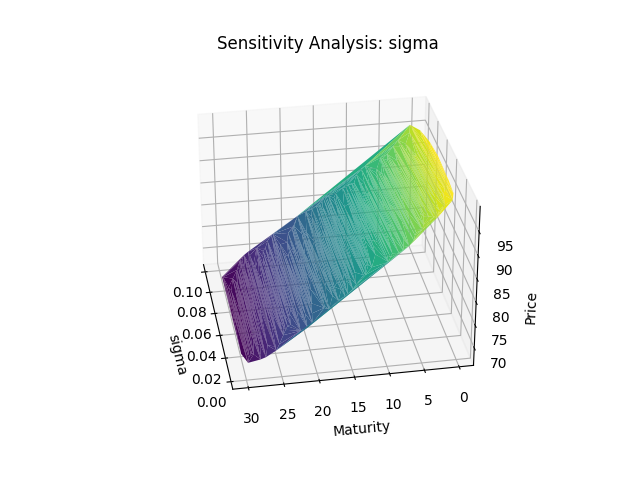

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        sigma_list, maturities, sigma_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: sigma');

ax.set_xlabel('sigma')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 170, 0)

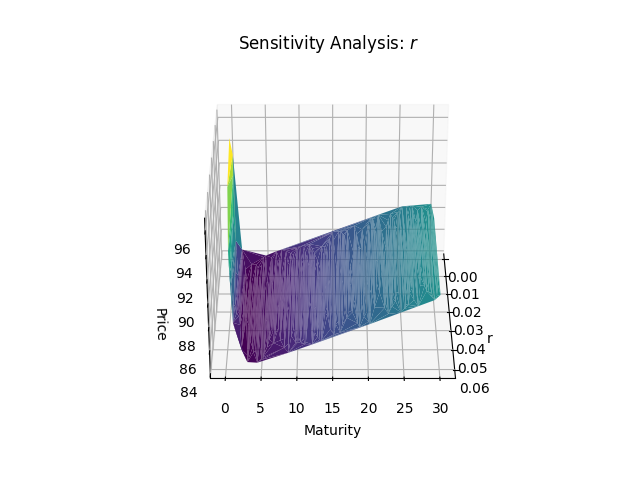

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        r_list, maturities, r_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: $r$');

ax.set_xlabel('r')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 0, 0)

p is decreasing in r
increasing in sigma
decreasing in a

r ̄ = 0.042994 (0.0080023) κ = 0.162953 (0.053703)
σ = 0.015384 (0.00099592).


### 4.1 Market Data Analysis

In [ ]:
maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '10Y', '20Y', '30Y']
dataframe = pd.DataFrame()

for maturity in maturities:

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv', index_col = 0)[['Bond Price', 'Price']]
    df.rename(columns = {"Bond Price": f'{maturity}', 'Price': f'{maturity} Yield'}, inplace = True)
    dataframe = pd.concat([dataframe, df], axis=1, join='outer')

dataframe.head()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 5))
dataframe[maturities].rolling(20).mean().plot(cmap = 'viridis', ax=ax[0]);
dataframe[[f'{maturity} Yield' for maturity in maturities]].rolling(20).mean().plot(cmap = 'viridis', ax=ax[1]);
ax[0].set_title('Bond Price');
ax[1].set_title('Yields');

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 5))
(np.sqrt(12)*dataframe[maturities].rolling(20).std()).plot(cmap = 'viridis', ax=ax[0]);
(np.sqrt(12)*dataframe[[f'{maturity} Yield' for maturity in maturities]].rolling(20).std()).plot(cmap = 'viridis', ax=ax[1]);
ax[0].set_title('Bond Price');
ax[1].set_title('Yields');